# Perceptron & Multi-Layer Perceptron (MLP): Nonlinear Data


In this notebook we will study the performance of the Perceptron model on a non-linear data set in comparison to another linear model, i.e., Logistic Regression. Then, we will study the performance of the Multi-Layer Perceptron (MLP), which is a non-linear model.

Since both Perceptron and Logistic Regression are **linear models**, they are unable to classsify non-linear data. We will see that these models won't create non-linear decision boundary.

One approach to classify non-linear data by using these linear models is to map the features onto a high-dimensional space such that data becomes linearly separable.

However, this solution suffers from the **curse of dimensionality** when the dataset is high-dimensional (e.g., image classfication problems in which number of features are very large.). Thus feature augmentation is not a feasible solution for high-dimensional non-linear data.

We have seen that using the **kernel trick** we can bypass the curse of dimensionality. The Gaussian Radial Basis Function (RBF) kernel based Support Vector Machine (SVM) classifier can create non-linear decision boundary without exploding the feature dimension. However, the dual optimization problem that we use to derive optimal solution for the kernel SVM is infeasible for large data set (it's complexity is $O(N^2d)$ ~ $O(N^3d)$).

### Very Large and Non-Linear Dataset

Thus, for a very large and non-linear data set, we need a model that does the classification without exploding the feature space.

To achieve this goal, we use **non-linear** models. 

The Multi-Layer Perceptron (MLP) or Artificial Neural Network (ANN) is a non-linear model that is able to create non-linear decision boundary.

In this notebook we will see how to classify a non-linear dataset using the MLP. But before that we will attempt to classify the data using Perceptron and Logistic Regression. 


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_circles

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Function for Drawing Decision Boundary

We use two functions for plotting the decision boundary:
- Equation based
- Class probability based

Detail discussion on these two functions are given in the "Logistic Regression - Binary Classification" notebook.

In [2]:
def decision_boundary_equation_based(clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    x1 = np.linspace(xmin, xmax, 100)
    decision_boundary = -(b + w[0]*x1)/w[1]
    plt.plot(x1, decision_boundary, "k--", linewidth=3)
    
    
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()
    

# Dataset

We will use Scikit-Learn's "datasets.make_circles" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates a large circle containing a smaller circle in 2d.

The following two parameters are used by the make_circles function:

- factor : Scale factor between inner and outer circle. Range 0 ~ 1.

- noise : Standard deviation of Gaussian noise added to the data.

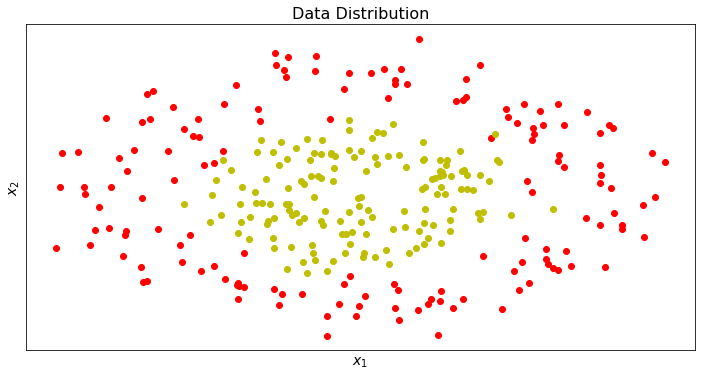

In [3]:
X, y = make_circles(300, factor=0.4, noise=0.15, random_state=0)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

## Split Data Into Training and Test Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Logistic Regression

In [5]:
%%time
param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
              'tol': [1e-3, 1e-4], 'max_iter':[500, 1000],'C': [1, 10, 50]}

lg_reg = LogisticRegression()

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='accuracy', cv=5)
lg_reg_cv.fit(X_train, y_train)

params_optimal = lg_reg_cv.best_params_

print("Best Score (accuracy): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Best Score (accuracy): 0.608333
Optimal Hyperparameter Values:  {'solver': 'liblinear', 'C': 10, 'max_iter': 500, 'tol': 0.001}
CPU times: user 703 ms, sys: 6 ms, total: 709 ms
Wall time: 711 ms


/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [6]:
lg_reg_clf = LogisticRegression(**params_optimal)

lg_reg_clf.fit(X_train, y_train)

print("No. of Iterations:", lg_reg_clf.n_iter_ )
print("\nWeight Intercept:", lg_reg_clf.intercept_ )
print("Weight Coefficients:", lg_reg_clf.coef_ )


y_train_predicted = lg_reg_clf.predict(X_train)
#print(y_test_predict)

train_accuracy_logreg = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_logreg)

No. of Iterations: [3]

Weight Intercept: [0.11777709]
Weight Coefficients: [[-0.18021236 -0.16441557]]

Training Accuracy:  0.6833333333333333


## Logistic Regression: Evaluation on Test Data

In [7]:
y_test_predicted = lg_reg_clf.predict(X_test)


test_accuracy_logreg = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_logreg)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.5833333333333334

Test Confusion Matrix:
[[12 25]
 [ 0 23]]

Test Precision = 0.479167
Test Recall = 1.000000
Test F1 Score = 0.647887

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.32      0.49        37
           1       0.48      1.00      0.65        23

   micro avg       0.58      0.58      0.58        60
   macro avg       0.74      0.66      0.57        60
weighted avg       0.80      0.58      0.55        60



## Perceptron

The only two hyperparameters that we can possibly tune are.
- tol : The stopping criterion. Defaults to 1e-3.
- max_iter : The maximum number of passes over the training data (aka epochs). 

We can find optimal values for these two hyperparameter (using grid search). 

In [8]:
%%time
param_grid = {'tol': [1e-3, 1e-4], 'max_iter':[1000, 5000]}

clf_perceptron = Perceptron()

clf_perceptron_cv = GridSearchCV(clf_perceptron, param_grid, scoring='accuracy', cv=5)
clf_perceptron_cv.fit(X_train, y_train)

params_optimal_perceptron = clf_perceptron_cv.best_params_

print("Best Score (accuracy): %f" % clf_perceptron_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_perceptron)

Best Score (accuracy): 0.508333
Optimal Hyperparameter Values:  {'max_iter': 1000, 'tol': 0.001}
CPU times: user 33.5 ms, sys: 2.45 ms, total: 36 ms
Wall time: 33.8 ms


/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [9]:
#perceptron_clf = Perceptron(tol=1e-6, max_iter=1000)
perceptron_clf = Perceptron(**params_optimal_perceptron)

perceptron_clf.fit(X_train, y_train)

print("No. of Iterations:", perceptron_clf.n_iter_ )
print("\nWeight Intercept:", perceptron_clf.intercept_ )
print("Weight Coefficients:", perceptron_clf.coef_ )


y_train_predicted = perceptron_clf.predict(X_train)
#print(y_test_predict)

train_accuracy_perceptron = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_perceptron)

No. of Iterations: 12

Weight Intercept: [0.]
Weight Coefficients: [[-1.59464376  0.14756926]]

Training Accuracy:  0.5375


## Perceptron: Evaluation on Test Data

In [10]:
y_test_predicted = perceptron_clf.predict(X_test)

test_accuracy_perceptron = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_perceptron)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.5166666666666667

Test Confusion Matrix:
[[19 18]
 [11 12]]

Test Precision = 0.400000
Test Recall = 0.521739
Test F1 Score = 0.452830

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.51      0.57        37
           1       0.40      0.52      0.45        23

   micro avg       0.52      0.52      0.52        60
   macro avg       0.52      0.52      0.51        60
weighted avg       0.54      0.52      0.52        60



## Decision Boundary I: Equation Based

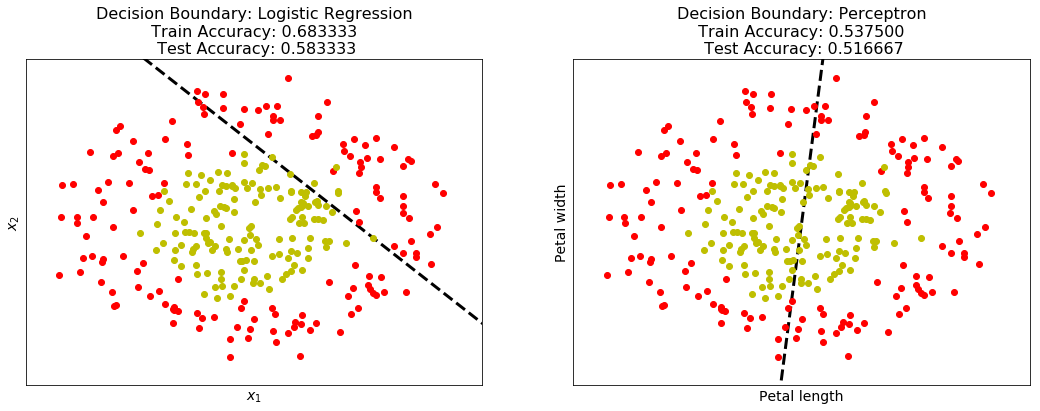

In [11]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_equation_based(lg_reg_clf, X)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_equation_based(perceptron_clf, X)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())

plt.show()

## Decision Boundary II: Class Probability Based

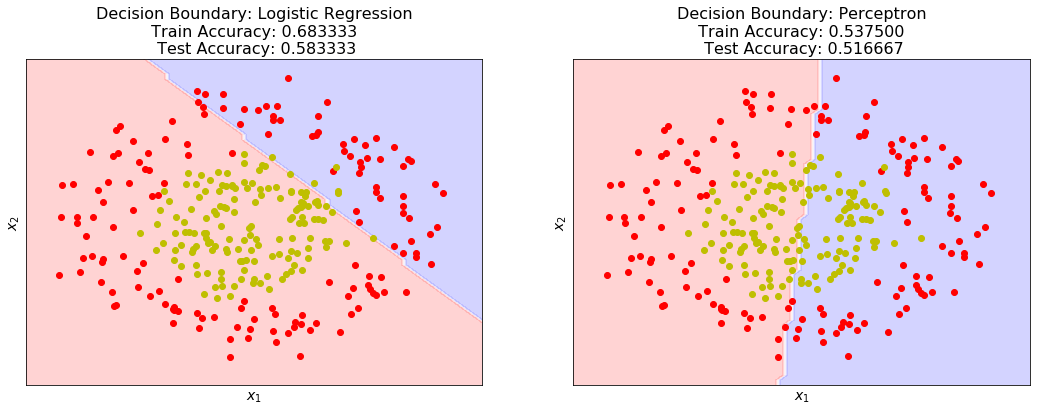

In [12]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_class_colored(lg_reg_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(perceptron_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.xticks(())
plt.yticks(())

plt.show()

## Observation

We see that both the Perceptron and Logistic Regression are unable to classify non-linear data. Because both are **linear models**.

To create complex decision boundary, we can use non-linear models. 

Below we will train a Multi-Layer Perceptron (MLP) which is a non-linear model.

However, we should note that a MLP is **not composed of multiple Perceptrons**. The discontinuous non-linearity of the Perceptron step-function makes it unsuitable for gradient descent based algorithms. 

Instead MLP is designed using Logistic Regressors. Intially the choice of the activation function was logistic sigmoid. Later other continuous non-linear activation functions were introduced for better performance.



## Multi-Layer Perceptron (MLP)


Scikit-Learn's MLPClassifier model uses **Backpropagation** to implement the Multi-Layer Perceptron (MLP) algorithm.

More precisely, it trains using some form of gradient descent and the gradients are calculated using Backpropagation. For classification, it minimizes the Cross-Entropy loss function, giving a vector of probability estimates per sample.

MLP trains on two arrays: 
- Array X of size (n_samples, n_features), which holds the training samples represented as floating point feature vectors.
- Array y of size (n_samples,), which holds the target values (class labels) for the training samples.

MLPClassifier supports multi-class classification by applying Softmax as the output function.

Further, the model supports multi-label classification in which a sample can belong to more than one class. For each class, the raw output passes through the logistic function. Values larger or equal to 0.5 are rounded to 1, otherwise to 0. 

### Limitations

Although MLP is a great tool for classifying non-linear data, it has some limitations.

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore, different random weight initializations can lead to different validation accuracy.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling.


### Regularization

Both MLPRegressor and MLPClassifier use parameter alpha for regularization (L2 regularization) term which helps in avoiding overfitting by penalizing weights with large magnitudes. 

## Algorithms

MLP trains using one of the following three algorithms: 
- Stochastic Gradient Descent
- Adam
- L-BFGS


Adam is similar to SGD in a sense that it is a stochastic optimizer, but it can automatically adjust the amount to update parameters based on adaptive estimates of lower-order moments.

With SGD or Adam, training supports online and mini-batch learning.

L-BFGS is a solver that approximates the Hessian matrix which represents the second-order partial derivative of a function. Further it approximates the inverse of the Hessian matrix to perform parameter updates. 

- ADAM works pretty well on relatively **large datasets (with thousands of training samples or more)** in terms of both training time and validation score. 
- For small datasets, however, LBFGS can converge faster and perform better.

## Scaling

Multi-layer Perceptron is sensitive to feature scaling. So it is highly recommended to scale the data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that we must apply the same scaling to the test set for meaningful results.

In [13]:
scaler = StandardScaler()  

# fit only on the training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# apply same transformation to test data
X_test = scaler.transform(X_test)  

## Model Selection via Hyperparameter Tuning



We provide some key hyperparameters for tuning. Please see the link below for more hyperparameters.
- hidden_layer_sizes: it's a tuple. Example: if we want 2 hidden layers with 10 and 2 neurons respectively, then we should set it as (10, 2).
- activation : choices are 'identity', ‘logistic’, ‘tanh’, ‘relu’. The default is ‘relu’.
- solver : choices are ‘lbfgs’, ‘sgd’, ‘adam’. The default is 'adam' which is good for very large dataset. 'lbfgs' can converge faster and perform better on small dataset. 
- alpha : L2 penalty (regularization term) parameter.
- learning_rate : Choices are ‘constant’, ‘invscaling’, ‘adaptive’. The default is ‘constant’.
        -- ‘invscaling’ gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)
        -- ‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.
        
- learning_rate_init : The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
        
- max_iter : Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

- tol : Tolerance for the optimization. 

- verbose : bool, optional, default False. Whether to print progress messages to stdout.


More info: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

## Grid Search for Model Selection

We skip the grid search part. The following code illustrates how to set the parameter values for grid search.

In [16]:
# %%time

# param_grid = {'hidden_layer_sizes': [(3,), (5,), (10,)], "solver":['sgd', 'lbfgs'], 
#            "max_iter": np.arange(100, 200), "alpha": (0.0001, 0.001, 0.01),
#              'activation': ['logistic', 'relu']}

# clf_mlp = MLPClassifier()

# clf_mlp_cv = GridSearchCV(clf_mlp, param_grid, scoring='accuracy', cv=5)
# clf_mlp_cv.fit(X_train, y_train)


# params_optimal_mlp = clf_mlp_cv.best_params_

# print("Best Score (accuracy): %f" % clf_mlp_cv.best_score_)
# print("Optimal Hyperparameter Values: ", params_optimal_mlp)


## MLP: Train the Model using Optimal Hyperparameters

In [17]:
# mlp_clf = MLPClassifier(**params_optimal_mlp)

mlp_clf = MLPClassifier(random_state=42, hidden_layer_sizes=(3, ), alpha=0.01, solver='lbfgs',
                      max_iter=100, learning_rate = 'adaptive', activation='logistic', verbose=True)

mlp_clf.fit(X_train, y_train)

print("No. of Iterations:", mlp_clf.n_iter_ )

y_train_predicted = mlp_clf.predict(X_train)

train_accuracy_mlp = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_mlp)

No. of Iterations: 101

Training Accuracy:  0.9708333333333333


## MLP: Evaluation on Test Data

In [18]:
y_test_predicted = mlp_clf.predict(X_test)

test_accuracy_mlp = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_mlp)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Test Accuracy:  0.9666666666666667

Test Confusion Matrix:
[[35  2]
 [ 0 23]]

Test Precision = 0.920000
Test Recall = 1.000000
Test F1 Score = 0.958333

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.92      1.00      0.96        23

   micro avg       0.97      0.97      0.97        60
   macro avg       0.96      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



## Decision Boundary: MLP vs Perceptron

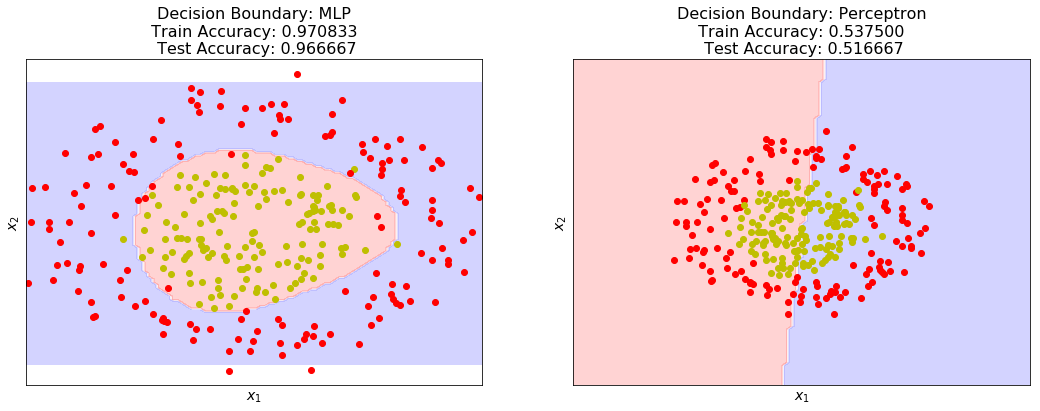

In [19]:
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_class_colored(mlp_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X_train[y_train.ravel()==0, 0], X_train[y_train.ravel()==0, 1], "ro")
plt.plot(X_train[y_train.ravel()==1, 0], X_train[y_train.ravel()==1, 1], "yo")
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "ro")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: MLP\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_mlp, test_accuracy_mlp) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(perceptron_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Perceptron\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_perceptron, test_accuracy_perceptron) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()